In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

import bemcs


# Define geometry of single element model

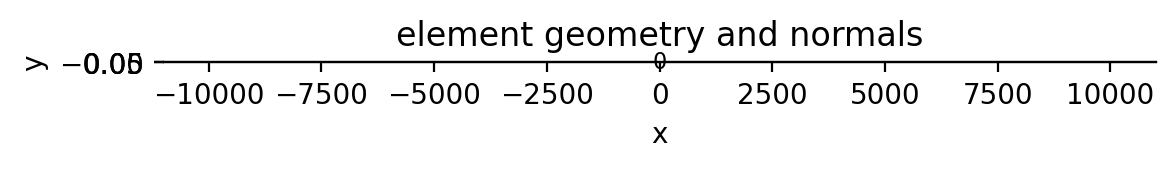

In [2]:
# List of elements for forward model
n_els = 1
mu = 3e10
nu = 0.25
L = 10000
x1, y1, x2, y2 = bemcs.discretized_line(-L, 0, L, 0, n_els)
els = bemcs.initialize_els()
els.x1 = np.copy(x1)
els.y1 = np.copy(y1)
els.x2 = np.copy(x2)
els.y2 = np.copy(y2)
bemcs.standardize_els_geometry(els)
bemcs.plot_els_geometry(els)

# Observation coordinates

In [3]:
n_pts = 100
width = 20000
x_obs = np.linspace(-width, width, n_pts)
y_obs = np.linspace(-width, width, n_pts)
x_obs, y_obs = np.meshgrid(x_obs, y_obs)
x_obs = x_obs.flatten()
y_obs = y_obs.flatten()

# Single constant slip element

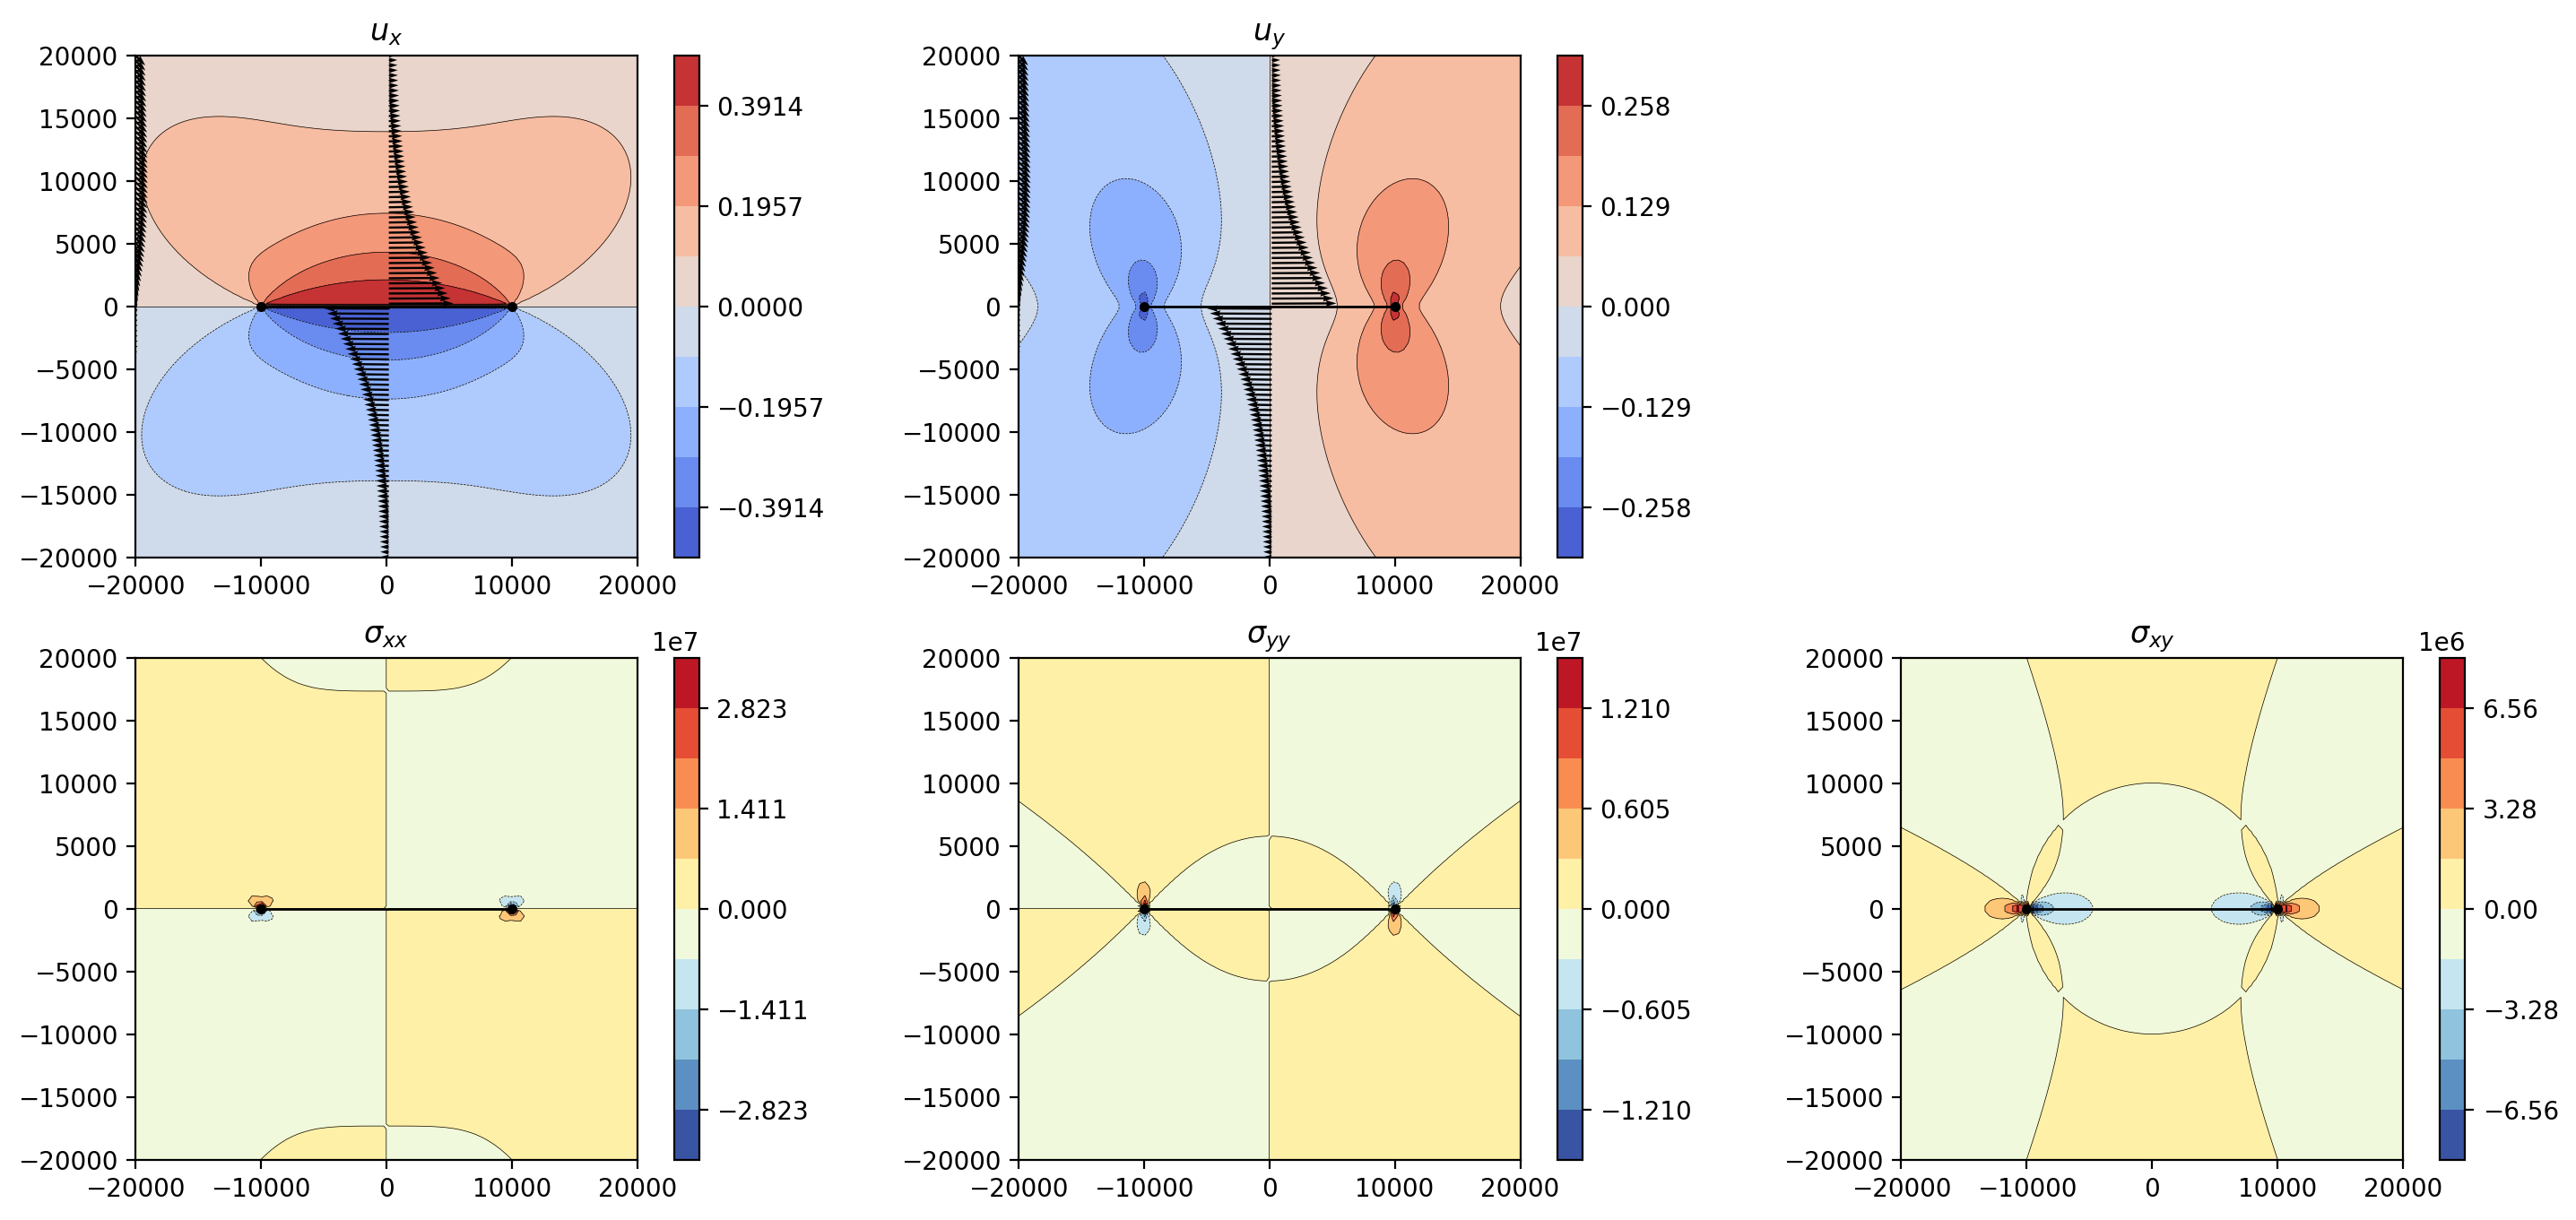

In [4]:
strike_slip_constant = 1
tensile_slip_constant = 0

(
    displacement_constant,
    stress_constant,
) = bemcs.displacements_stresses_constant_no_rotation(
    x_obs,
    y_obs,
    els.half_lengths[0],
    mu,
    nu,
    strike_slip_constant,
    tensile_slip_constant,
    els.x_centers[0],
    els.y_centers[0],
)

ux = displacement_constant[0, :]
uy = displacement_constant[1, :]
sxx = stress_constant[0, :]
syy = stress_constant[1, :]
sxy = stress_constant[2, :]

bemcs.plot_displacements_stresses_els(
    els, n_pts, ux, uy, sxx, syy, sxy, x_obs, y_obs, n_skip_plot=50
)

# Why is there a sign change in $\sigma_{xy}$ with distance perpendicular to the fault trace?
At $x=0$, $u_y$ should be zero so that only contribution to $\sigma_{xy}$ should be the gradient in $u_x$ with $y$.  As far as I can tell (visually) $u_x$ decreases in magnitute monotonically with distance away from the the fault trace (at $x=0$).  Thus I am puzzled as to how $\sigma_{xy}$ can change sign.

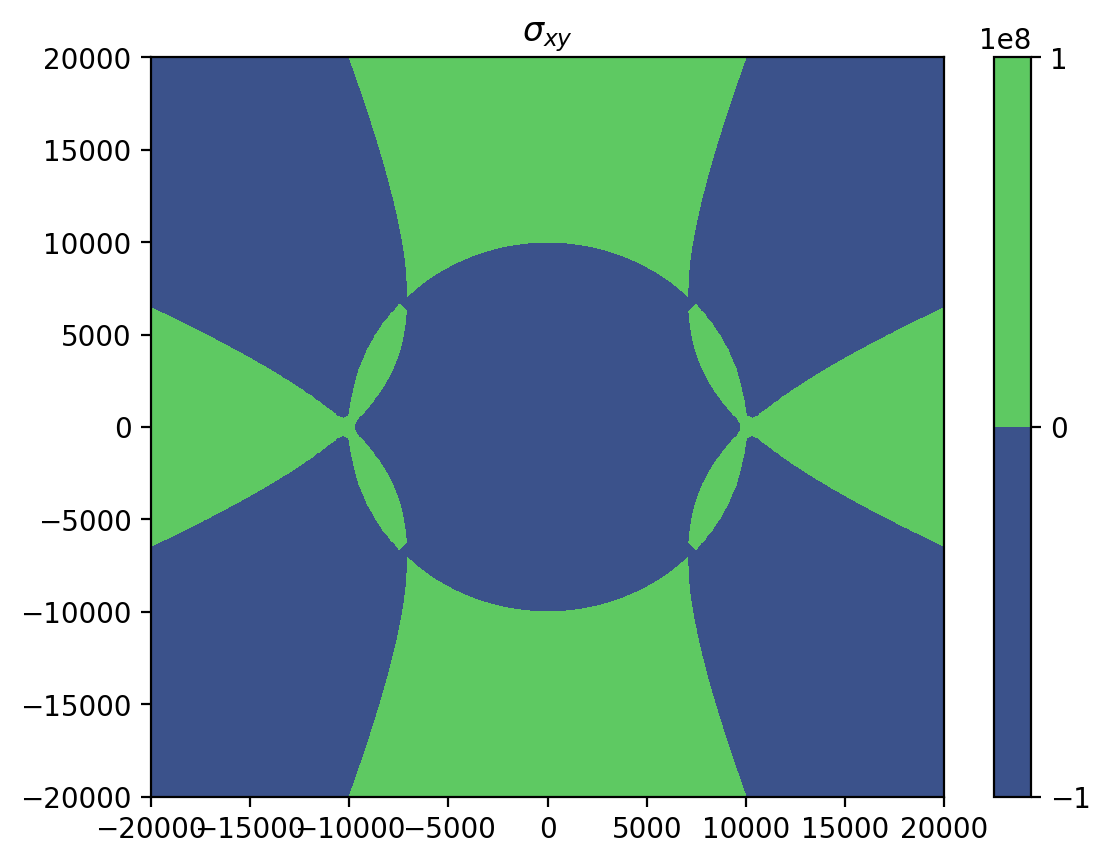

In [5]:
plt.figure()
plt.contourf(
    x_obs.reshape(n_pts, n_pts),
    y_obs.reshape(n_pts, n_pts),
    sxy.reshape(n_pts, n_pts),
    levels=[-1e8, 0, 1e8],
)
plt.colorbar()
plt.title("$\sigma_{xy}$")
plt.show()

# Numerical strains and stresses

In [6]:
ux_mat = ux.reshape(n_pts, n_pts)
uy_mat = uy.reshape(n_pts, n_pts)
dux_dx_mat, dux_dy_mat = np.gradient(ux_mat)
duy_dx_mat, duy_dy_mat = np.gradient(uy_mat)

exx_mat = dux_dx_mat
eyy_mat = duy_dy_mat
exy_mat = 0.5 * (dux_dy_mat + duy_dx_mat)

lambda_ = mu
sxx_mat = lambda_ * (exx_mat + eyy_mat) / 3 + 2 * mu * exx_mat
syy_mat = lambda_ * (exx_mat + eyy_mat) / 3 + 2 * mu * eyy_mat
sxy_mat = 2 * mu * exy_mat

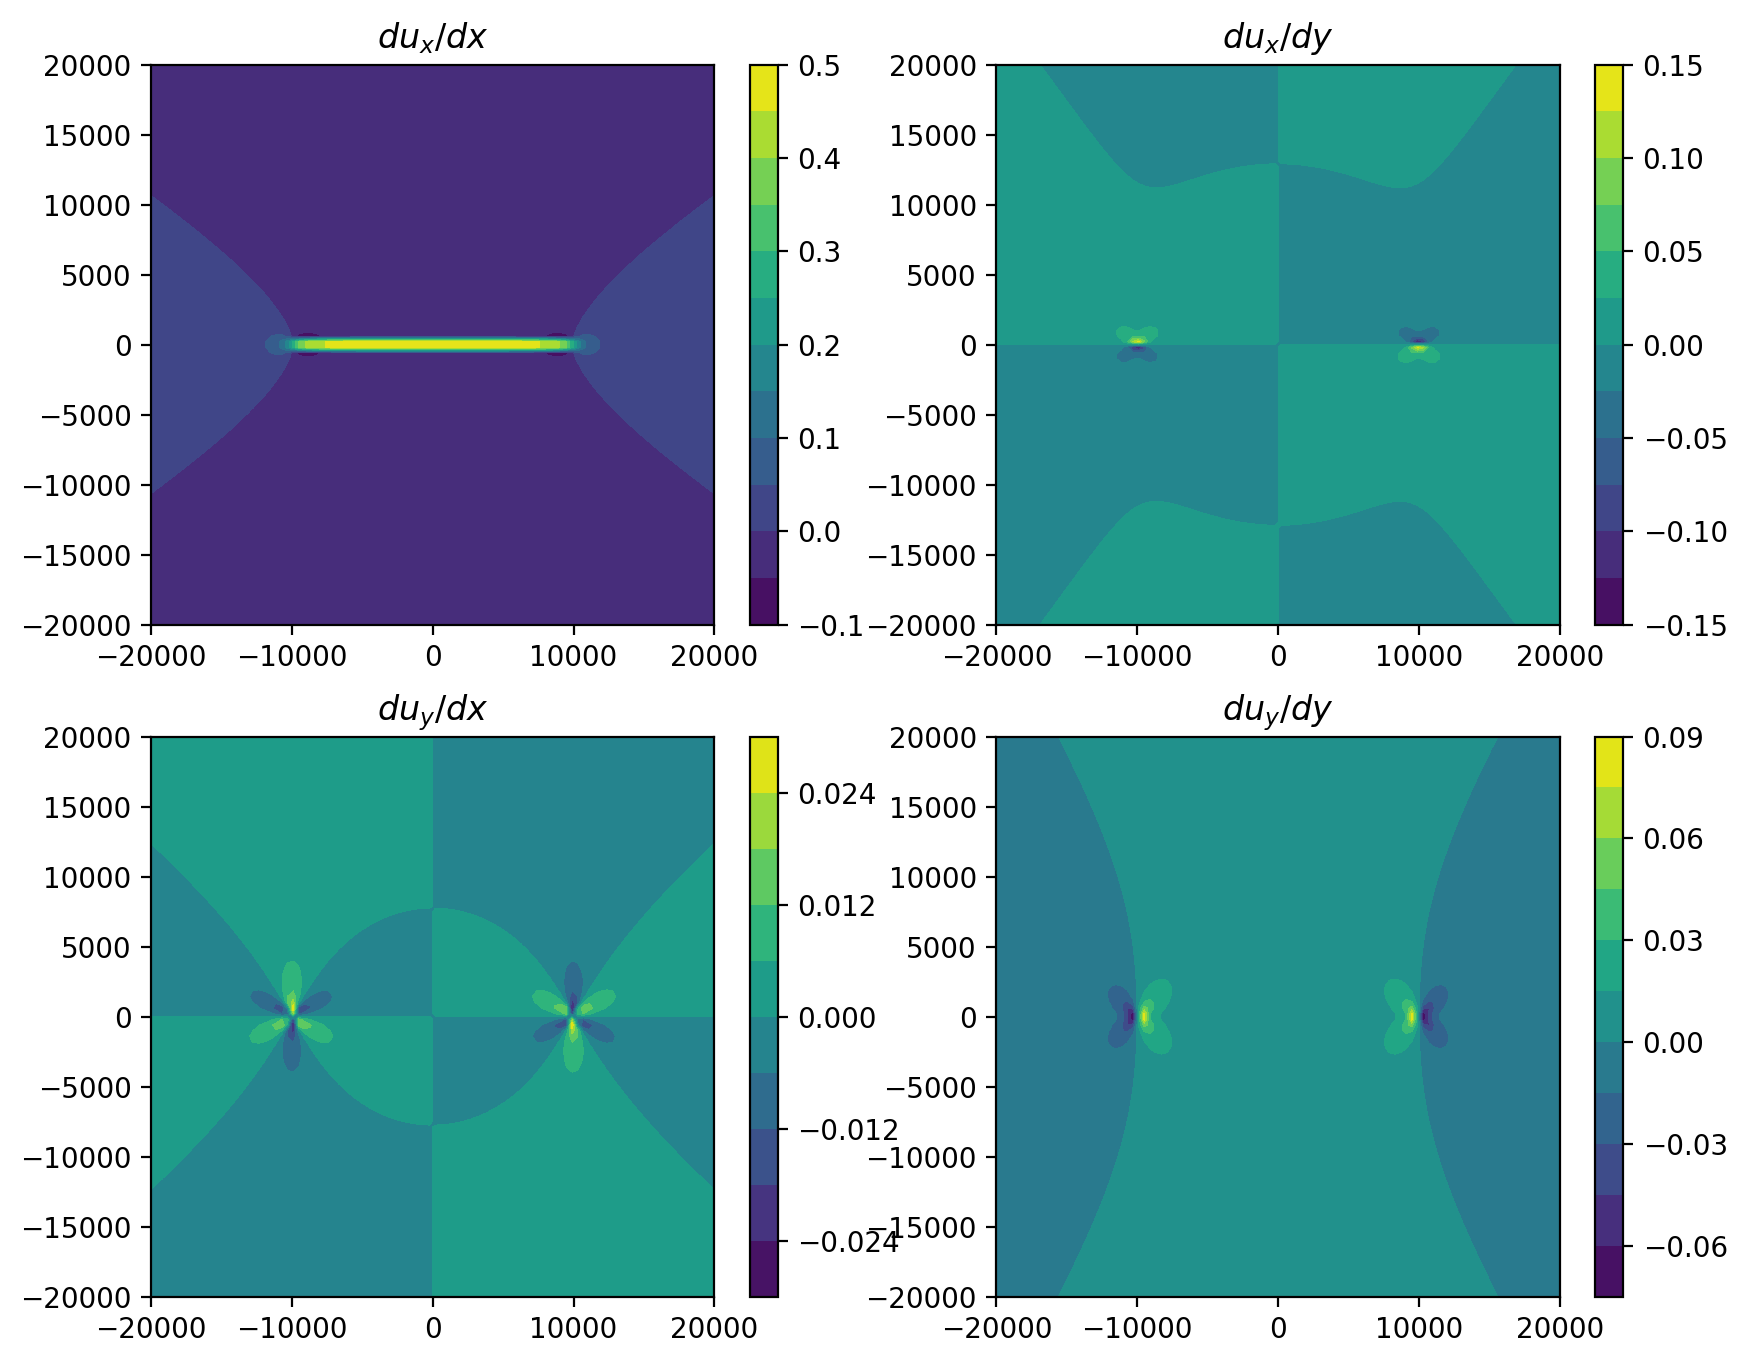

In [7]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.contourf(
    x_obs.reshape(n_pts, n_pts),
    y_obs.reshape(n_pts, n_pts),
    dux_dx_mat,
    levels=10,
)
plt.colorbar()
plt.title("$du_x / dx$")

plt.subplot(2, 2, 2)
plt.contourf(
    x_obs.reshape(n_pts, n_pts),
    y_obs.reshape(n_pts, n_pts),
    dux_dy_mat,
    levels=10,
)
plt.colorbar()
plt.title("$du_x / dy$")

plt.subplot(2, 2, 3)
plt.contourf(
    x_obs.reshape(n_pts, n_pts),
    y_obs.reshape(n_pts, n_pts),
    duy_dx_mat,
    levels=10,
)
plt.colorbar()
plt.title("$du_y / dx$")

plt.subplot(2, 2, 4)
plt.contourf(
    x_obs.reshape(n_pts, n_pts),
    y_obs.reshape(n_pts, n_pts),
    duy_dy_mat,
    levels=10,
)
plt.colorbar()
plt.title("$du_y / dy$")

plt.show()

# Plot numerically estimated stresses

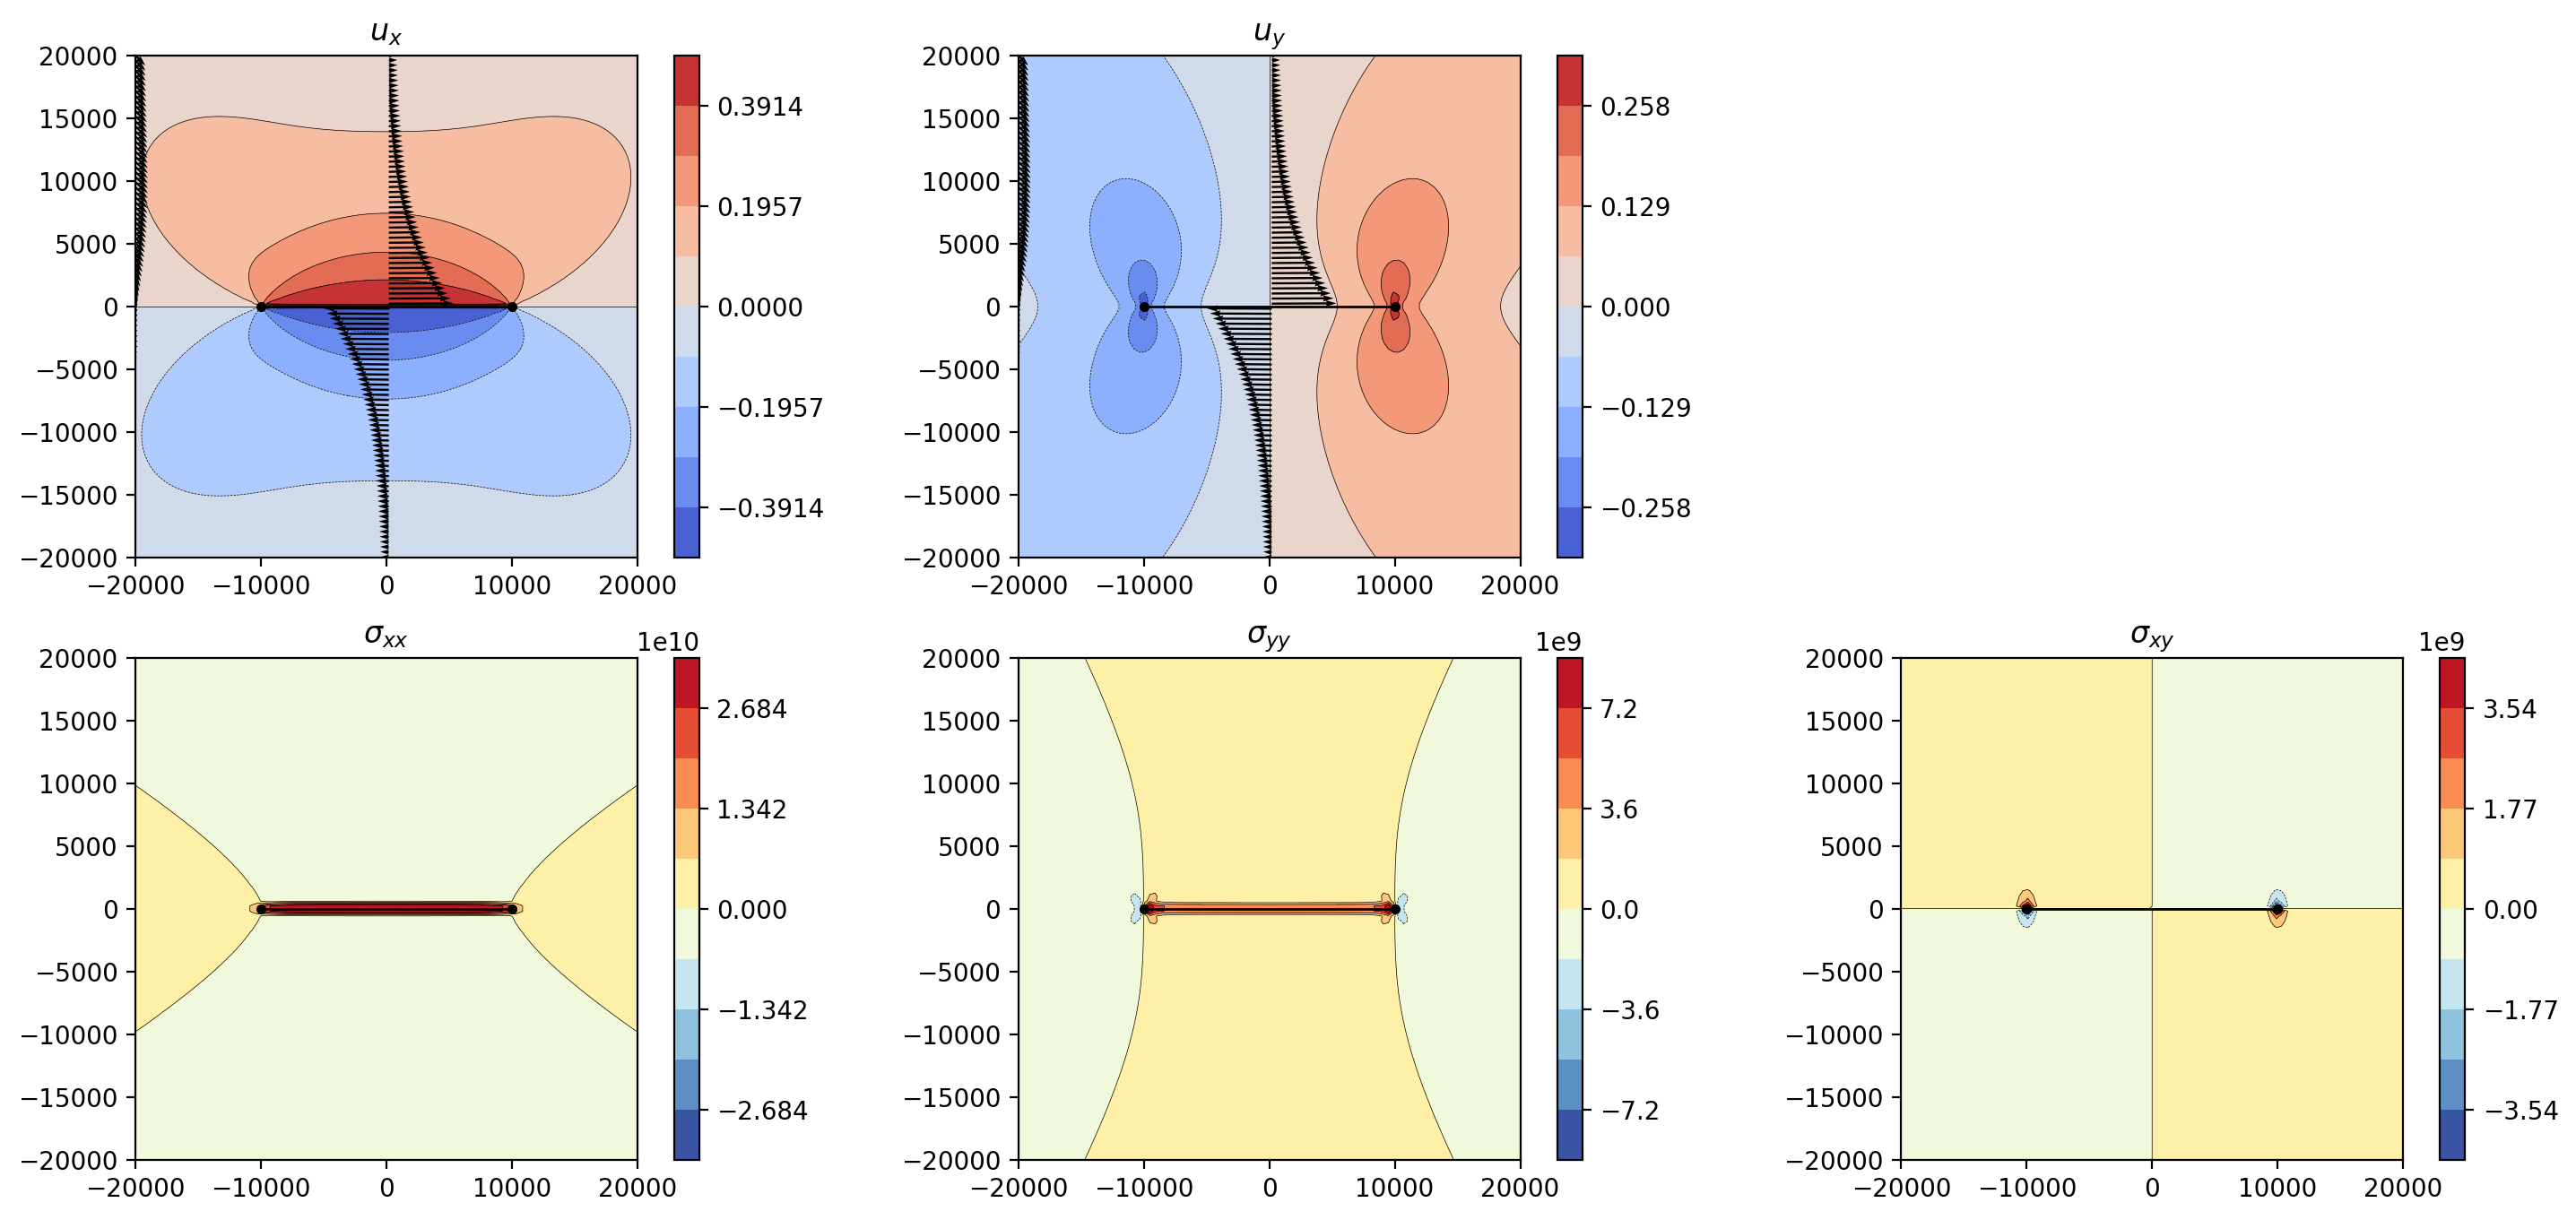

In [8]:
bemcs.plot_displacements_stresses_els(
    els,
    n_pts,
    ux,
    uy,
    sxx_mat.flatten(),
    syy_mat.flatten(),
    sxy_mat.flatten(),
    x_obs,
    y_obs,
    n_skip_plot=50,
)

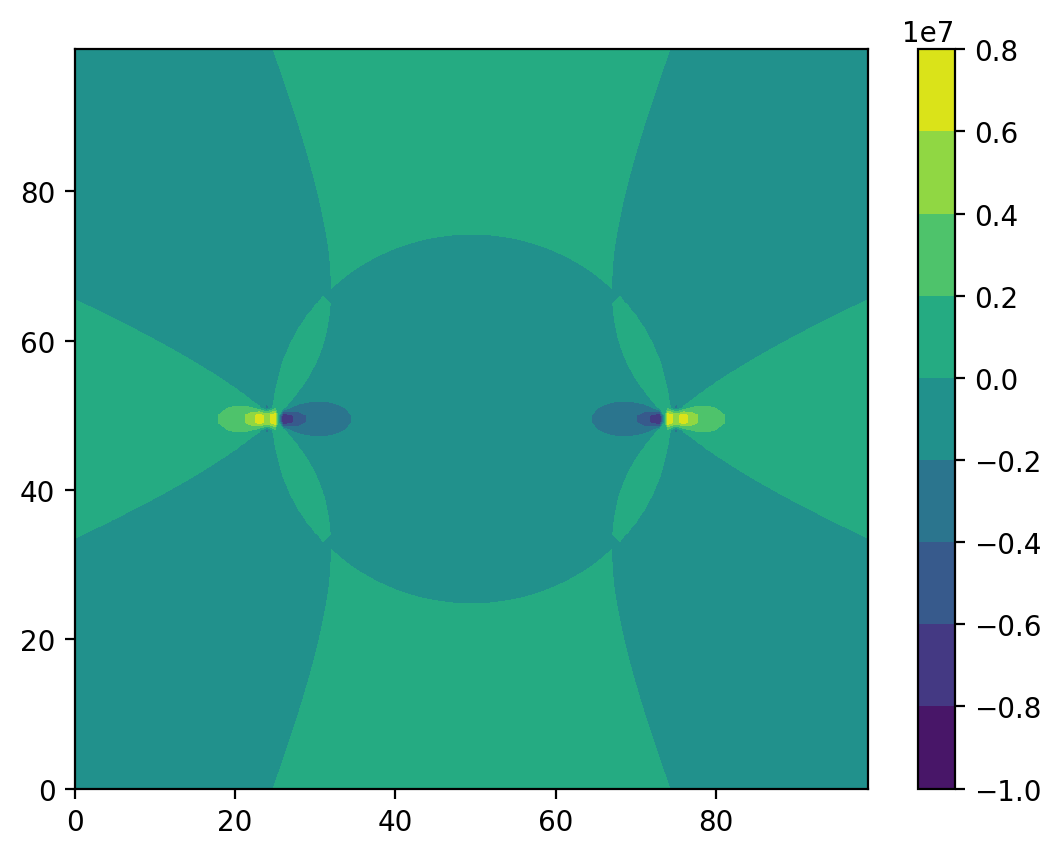

In [15]:
plt.contourf(sxy.reshape(n_pts, n_pts))
plt.colorbar()

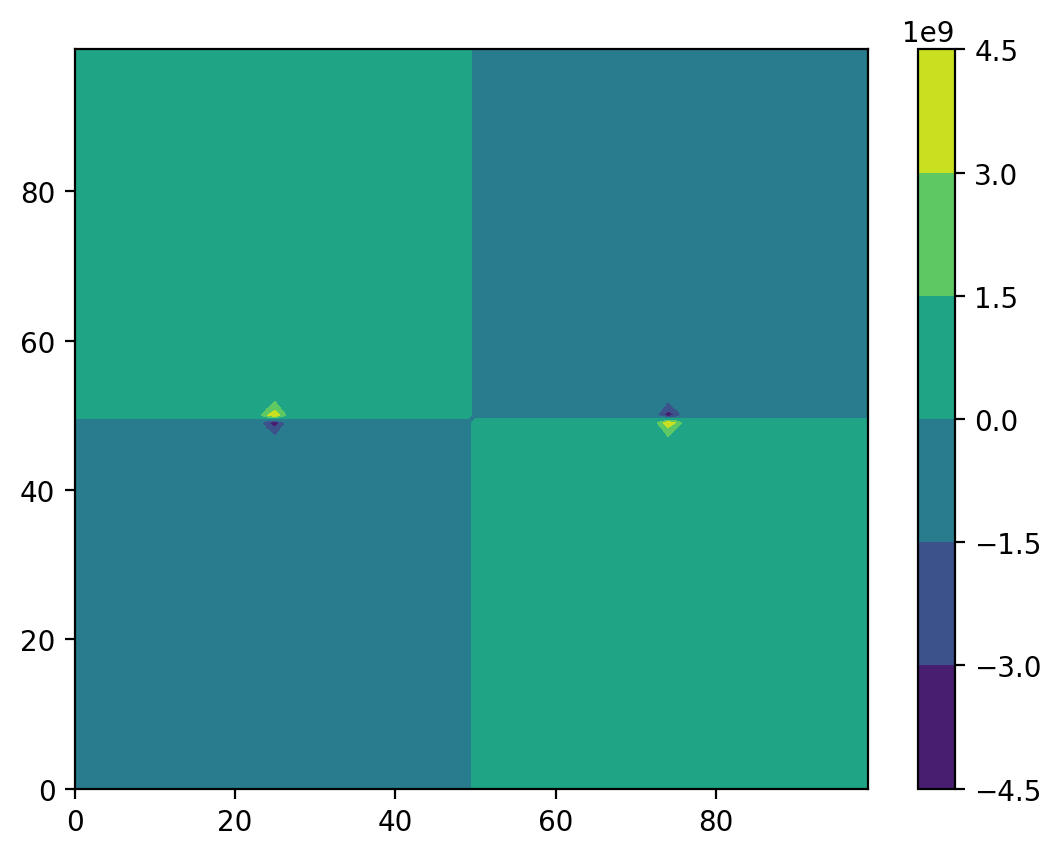

In [16]:
plt.contourf(sxy_mat)
plt.colorbar()